In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from csi.pipeline import kernels
import librosa
from librosa import display
from csi.vendor import simplefast
from csi.pipeline import ssm as ssmlib
import IPython.display as ipd

def generate_audio(files):
    audios = []
    for f in files:
        y, sr = librosa.load(f)
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
        seconds = len(y)/sr
        samples_per_beat = (60 * sr) / tempo
        audio = {'y': y, 'sr': sr, 'seconds': seconds, 'tempo': tempo, 'beats': beats, 'samples_per_beat': samples_per_beat}
        audios.append(audio)
    return audios
        
def generate_chromas(audios, hop_length=2**12):
    return [librosa.feature.chroma_cens(a['y'], a['sr'], hop_length=hop_length) for a in audios]

def generate_beatsync_feats(features, audios):
    return [beat_sync(features[idx], audios[idx]['beats']) for idx in range(len(features))]

def beat_sync(feature, beats):
    beat_f = librosa.util.fix_frames(beats, x_max=feature.shape[1])
    return librosa.util.sync(feature, beat_f, aggregate=np.median)
    
def generate_cic(chromas):
    return [calc_cic(f) for f in chromas]

def generate_din(chromas):
    return [calc_din(f) for f in chromas]

def calc_cic(crm_arr):
    crmip = np.zeros(12)
    tmtx = []
    for crmi in crm_arr:
        row_d = []
        for d in np.arange(-5,7,1):
            sum_crm = 0
            for i in range(12):
                sum_crm = sum_crm + (crmip[i]*crmi[(i+d)%12])
            row_d.append(sum_crm)
        #row_d = row_d/np.linalg.norm(row_d)
        row_d = (row_d-np.min(row_d))/(np.max(row_d)-np.min(row_d))
        crmip = crmi
        if not np.isnan(row_d).any():
            tmtx.append(row_d)
    tmtx = np.array(tmtx)
    tmtx = tmtx[1:-1,:].T
    tmtx = tmtx.tolist()
    return np.array(tmtx)

def calc_din(crm_arr):
    crmip = np.zeros(12)
    tmtx = []
    last_chroma = np.zeros(crm_arr.shape[1])
    for crmi in crm_arr.T:
        delta = []
        for i in range(12):
            delta.append(np.linalg.norm(np.roll(crmi,i) - last_chroma))
        nabla = np.max(delta) - delta
        nabla = (nabla-np.min(nabla))/(np.max(nabla)-np.min(nabla))
        if not np.isnan(nabla).any():
            tmtx.append(nabla)
        last_chroma = crmi
    tmtx = np.array(tmtx)
    tmtx = tmtx[1:-1,:].T
    tmtx = tmtx.tolist()
    return np.array(tmtx)

def normalize(x):
  arr = np.array(x) - min(x)
  return (arr/np.amax(arr))**2

def tokenize(feature, rows):
    indexes = np.array([np.argsort(1 - feature.T[i])[0:rows] for i in range(len(feature[0]))]).T
    words = [''.join([chr(a) for a in (x+65)]) for x in indexes.T]
    return ' '.join(words)


In [2]:
mazurkas = ['/dataset/mazurkas/mazurka07-5/pid9105-09.mp3',
'/dataset/mazurkas/mazurka07-5/pid9072-09.mp3',
'/dataset/mazurkas/mazurka07-5/pid9065-06.mp3',
'/dataset/mazurkas/mazurka07-5/pid9094-09.mp3',
'/dataset/mazurkas/mazurka07-5/pid9174-09.mp3',
'/dataset/mazurkas/mazurka07-5/pid9067-09.mp3',
'/dataset/mazurkas/mazurka06-4/pid9063-04.mp3',
'/dataset/mazurkas/mazurka06-4/pid9093-04.mp3',
'/dataset/mazurkas/mazurka06-4/pid9070-12.mp3',
'/dataset/mazurkas/mazurka06-4/pid9097-11.mp3',
'/dataset/mazurkas/mazurka06-4/pid9118-04.mp3',
'/dataset/mazurkas/mazurka06-4/pid9088-04.mp3',
'/dataset/mazurkas/mazurka07-4/pid9070-16.mp3',
'/dataset/mazurkas/mazurka07-4/pid9174-08.mp3',
'/dataset/mazurkas/mazurka07-4/pid9075-08.mp3',
'/dataset/mazurkas/mazurka07-4/pid9111-08.mp3',
'/dataset/mazurkas/mazurka07-4/pid9049-08.mp3',
'/dataset/mazurkas/mazurka07-4/pid9138-08.mp3',
'/dataset/mazurkas/mazurka17-4/pid9059-13.mp3',
'/dataset/mazurkas/mazurka17-4/pid9164-13.mp3',
'/dataset/mazurkas/mazurka17-4/pid9156-10.mp3',
'/dataset/mazurkas/mazurka17-4/pid9056-15.mp3',
'/dataset/mazurkas/mazurka17-4/pid9139-13.mp3',
'/dataset/mazurkas/mazurka17-4/pid9132-11.mp3'            
]

In [3]:
audios = generate_audio(mazurkas)

/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.5/dist-packages/librosa/cor

In [4]:
chromas = generate_chromas(audios, hop_length=2**11)

In [6]:
chroma_cics = generate_cic(chromas)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


In [5]:
beat_chromas = generate_beatsync_feats(chromas, audios)

In [7]:
beat_cics = generate_beatsync_feats(chroma_cics, audios)

In [596]:
#chroma_dins = generate_din(np.array(chromas))
#beat_dins = generate_beatsync_feats(chroma_dins, audios)

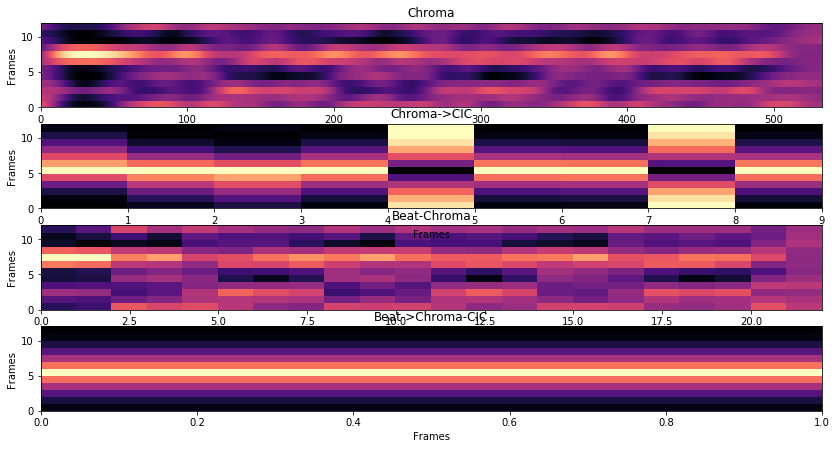

In [8]:
plt.figure(figsize=(14, 9))
plt.subplot(5, 1, 1)
display.specshow(chromas[0], y_axis='frames', x_axis='frames')
plt.title('Chroma')

plt.subplot(5, 1, 3)
display.specshow(beat_chromas[0], y_axis='frames', x_axis='frames')
plt.title('Beat-Chroma')

plt.subplot(5, 1, 2)
display.specshow(chroma_cics[0], y_axis='frames', x_axis='frames')
plt.title('Chroma->CIC')

plt.subplot(5, 1, 4)
display.specshow(beat_cics[0], y_axis='frames', x_axis='frames')
plt.title('Beat->Chroma-CIC')


plt.show()


In [9]:
feature = chromas
min_word_size = 2
max_word_size = 6


tokens_2 = [tokenize(f, 2) for f in feature]
tokens_3 = [tokenize(f, 3) for f in feature]
tokens_4 = [tokenize(f, 4) for f in feature]
tokens_5 = [tokenize(f, 5) for f in feature]

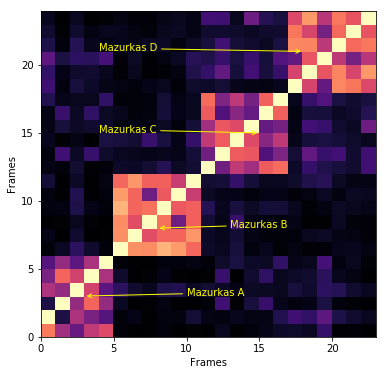

In [27]:
ngrams = 2

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(ngrams, ngrams))
my_features = vectorizer.fit_transform(tokens_2)
scores = np.array([(my_features[x, :] * my_features[1:, :].T).A[0] for x in range(len(feature))])
plt.figure(figsize=(6, 6))
display.specshow(scores, **{'y_axis':'frames', 'x_axis':'frames'})
plt.annotate("Mazurkas A",
            xy=(3, 3), xycoords='data',
            xytext=(10, 3), color='yellow', textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='yellow'),
            )
plt.annotate("Mazurkas B",
            xy=(8, 8), xycoords='data',
            xytext=(13, 8), color='yellow', textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='yellow'),
            )
plt.annotate("Mazurkas C",
            xy=(15, 15), xycoords='data',
            xytext=(4, 15), color='yellow', textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='yellow'),
            )
plt.annotate("Mazurkas D",
            xy=(18, 21), xycoords='data',
            xytext=(4, 21), color='yellow', textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='yellow'),
            )
plt.show()
